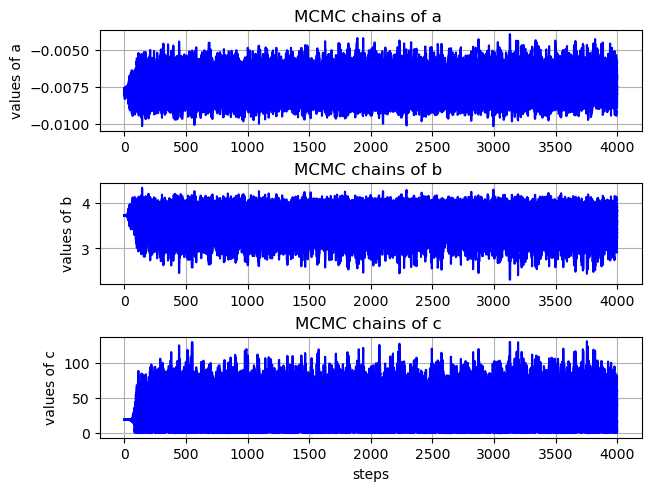

True values of parameter
a: -0.007537643179369601
b: 3.621356811596594
c: 26.84588226478024
One-Sigma Values of parameter 16th and 84th Percentile:
a: [-0.00823095 -0.00673732]
b: [3.34206401 3.83398543]
c: [ 9.78734482 50.38381193]


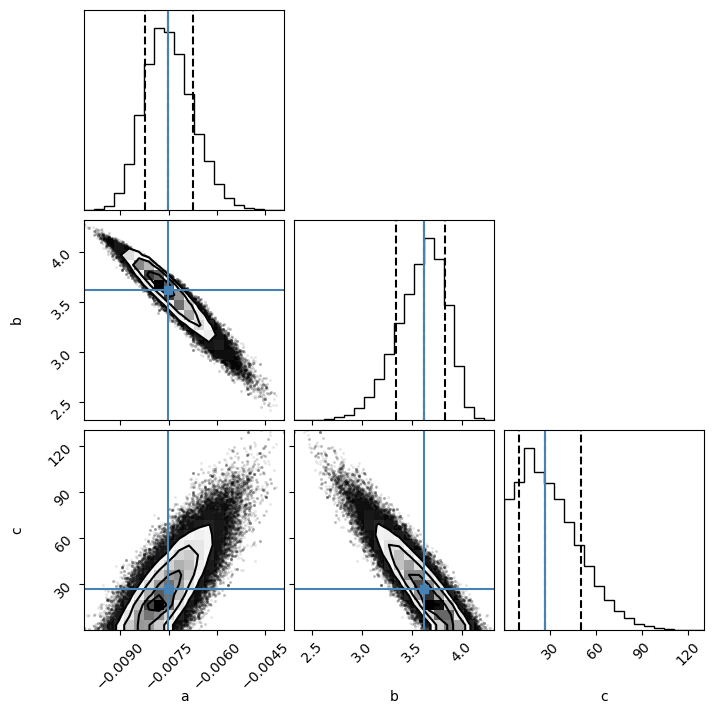

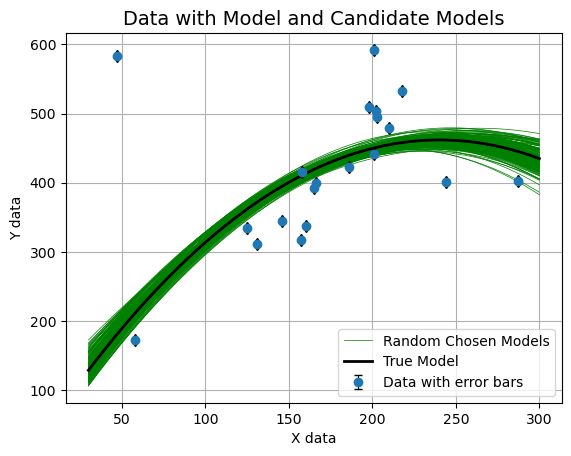

In [19]:
# Import necessary libraries
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import scipy.optimize as op

# Load data from file
x_data = np.loadtxt("D:\Amit\CP\Q10.txt", skiprows=5, usecols=1)
y_data = np.loadtxt("D:\Amit\CP\Q10.txt", skiprows=5, usecols=2)
sigma_y = np.loadtxt("D:\Amit\CP\Q10.txt", skiprows=5, usecols=3)

# Define the quadratic model function
def f(x, args):
    return args[0] * x**2.0 + args[1] * x + args[2]

# Define the log-likelihood function assuming Gaussian distribution
def log_likelihood(data_params, x, y, yerr):
    a, b, c = data_params
    model = a * x**2.0 + b * x + c
    sigma2 = yerr**2
    return 0.5 * np.sum((y - model)**2 / sigma2 + np.log(2 * np.pi * sigma2))

# Define the log-prior function for uniform priors
def log_prior(data_params):
    a, b, c = data_params
    if -200.0 < a < 200 and -500.0 < b < 500.0 and 0 < c < 1000.0:
        return 0.0
    return -np.inf

# Define the log-probability function as the sum of log-prior and log-likelihood
def log_probability(data_params, x, y, yerr):
    lp = log_prior(data_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp - log_likelihood(data_params, x, y, yerr)

# Initial guess of parameters
guess = (1.0, 1.0, 1.0)

# Minimize the negative log-likelihood to find the maximum likelihood estimates
soln = op.minimize(log_likelihood, guess, args=(x_data, y_data, sigma_y))

# Setup MCMC
nwalkers, ndim = 50, 3
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_data, y_data, sigma_y))
sampler.run_mcmc(pos, 4000)
samples = sampler.get_chain()

# Plot MCMC chains of the parameters
fig = plt.figure(constrained_layout=True)
spec = fig.add_gridspec(3, 1)
p1 = fig.add_subplot(spec[0, 0])
p1.set_title("MCMC chains of a ")
p1.plot(samples[:, :, 0], color='blue')
p1.set_ylabel("values of a")
p1.grid()
p2 = fig.add_subplot(spec[1, 0])
p2.set_title("MCMC chains of b ")
p2.plot(samples[:, :, 1], color='blue')
p2.set_ylabel("values of b")
p2.grid()
p3 = fig.add_subplot(spec[2, 0])
p3.set_title("MCMC chains of c ")
p3.plot(samples[:, :, 2], color='blue')
p3.set_xlabel("steps")
p3.set_ylabel("values of c")
p3.grid()
plt.show()

# Reshape samples
sph = samples.shape
samples = np.reshape(np.ravel(samples), (sph[0] * sph[1], sph[2]))

# Compute medians for true values
medians = np.median(samples, axis=0)
a_true, b_true, c_true = medians
print("True values of parameter\na:", a_true)
print("b:", b_true)
print("c:", c_true)

# Calculate 1-Sigma values
one_sigma_vals_a = corner.quantile(samples[:, 0], q=[0.16, 0.84])
one_sigma_vals_b = corner.quantile(samples[:, 1], q=[0.16, 0.84])
one_sigma_vals_c = corner.quantile(samples[:, 2], q=[0.16, 0.84])
print("One-Sigma Values of parameter 16th and 84th Percentile:\na:", one_sigma_vals_a)
print("b:", one_sigma_vals_b)
print("c:", one_sigma_vals_c)

# Plot the variations
fig2 = corner.corner(samples, labels=["a", "b", "c"], quantiles=[0.16, 0.5, 0.84], truths=[a_true, b_true, c_true])
plt.show()

# Extract 200 randomly selected data sets
index = np.random.randint(0, sph[0] * sph[1] - 1, size=200)
model_param = np.zeros(shape=(200, 3), dtype=np.float64)
for i in range(len(index)):
    model_param[i] = samples[index[i]]
x = np.linspace(30.0, 300.0, 200)

# Plot random models
for i in range(len(index)):
    if i == 0:
        plt.plot(x, f(x, model_param[i]), color='green', lw=0.5, label='Random Chosen Models')
    else:
        plt.plot(x, f(x, model_param[i]), color='green', lw=0.5)

# Plot the model with true parameters
plt.title("Data with Model and Candidate Models", size=14)
plt.plot(x, f(x, [a_true, b_true, c_true]), color='black', lw=2, label="True Model")

# Plot data with error bars
plt.errorbar(x_data, y_data, yerr=sigma_y, fmt='o', ecolor='black', elinewidth=0.75, lolims=True, uplims=True,
             label="Data with error bars")
plt.grid()
plt.xlabel("X data")
plt.ylabel("Y data")
plt.legend()
plt.show()
